In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random

# 1) Data cleaning:

## Firstly, all the images were changed from `png format to jpg format`, however, the updated folder `datacleaningglassesnoglasses` contains already this mentioned change

## Glasess:

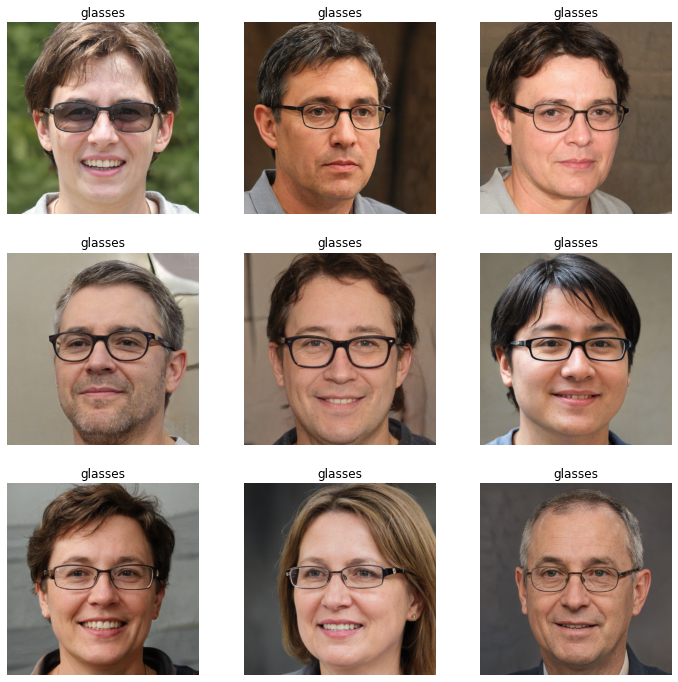

In [19]:
with open("train/glasses.txt", "rb") as fp:
    glasses = pickle.load(fp)

for i in range(len(glasses)):
    glasses[i] = glasses[i].replace('../input/glasses-or-no-glasses/faces-spring-2020', 'train')
    
plt.figure(figsize=(12, 12))
ran_num = []
for i in range(0,9):
    n = random.randint(0,len(glasses))
    ran_num.append(n)
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(glasses[ran_num[i]]))
    plt.title("glasses")
    plt.axis("off")

## No glasses:

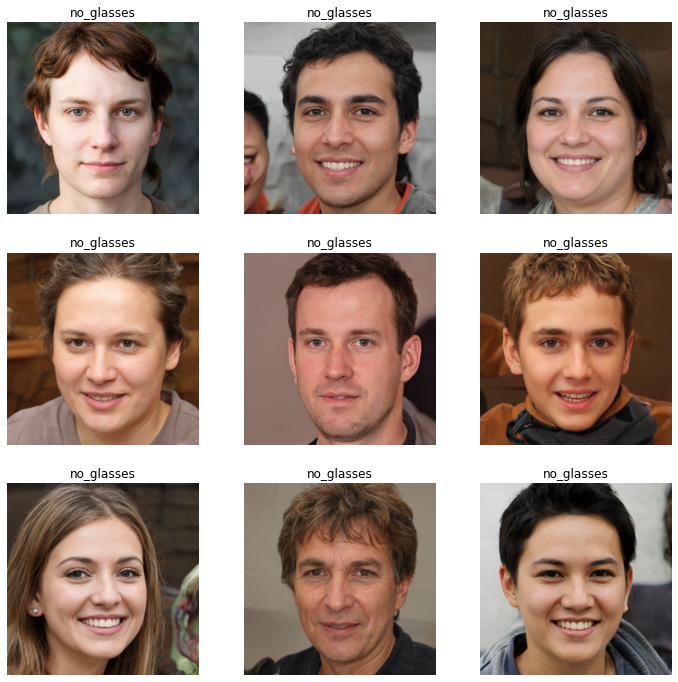

In [25]:
with open("train/no_glasses.txt", "rb") as fp: 
    no_glasses = pickle.load(fp)
    
for i in range(len(no_glasses)):
    no_glasses[i] = no_glasses[i].replace('../input/glasses-or-no-glasses/faces-spring-2020', 'train')

plt.figure(figsize=(12, 12))
ran_num = []
for i in range(0,9):
    n = random.randint(0,len(no_glasses))
    ran_num.append(n)
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(no_glasses[ran_num[i]]))
    plt.title("no_glasses")
    plt.axis("off")

## No clear:

### The data is created `artificially`, hence, in some photos it was not clear wheter the photos belong to the class `glasses` or `no_glasses`

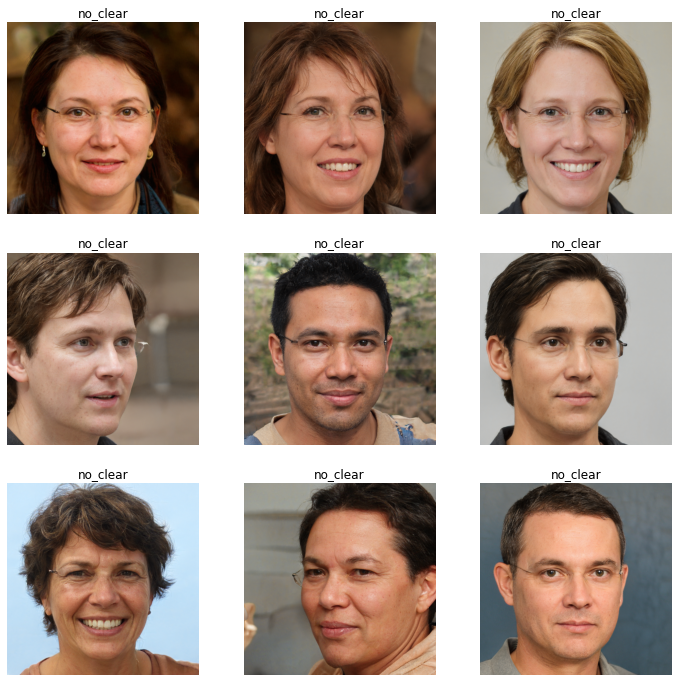

In [26]:
with open("train/no_clear.txt", "rb") as fp: 
    no_clear = pickle.load(fp)
    
for i in range(len(no_clear)):
    no_clear[i] = no_clear[i].replace('../input/glasses-or-no-glasses/faces-spring-2020', 'train')
    
plt.figure(figsize=(12, 12))
ran_num = []
for i in range(0,9):
    n = random.randint(0,len(no_clear))
    ran_num.append(n)
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(no_clear[ran_num[i]]))
    plt.title("no_clear")
    plt.axis("off")

In [27]:
print("The length of the different groups:" + "-Glasses: " + str(len(glasses)) + " -No glasses: " + str(len(no_glasses)) + " -No clear: " + str(len(no_clear)))

The length of the different groups:-Glasses: 2770 -No glasses: 2152 -No clear: 77


### It seems the data is `imbalance` there are `much more glasses images than no glasses images`. On the other hand, `77 images` are not going to be used in the model because are `not clear`

## The next model is based on Tensorflow/Learn/Tutorials/Images/Transfer learning and fine-tuning - https://www.tensorflow.org/tutorials

# 2) Data processing:

## In this project a `classification model` will be created in order to classify images of people with glasses and no glasses

## The `random seed` is going to be applied, it will be used along all the model. In this way we will be sure that the same random seed is applied when it is optional to be called

In [28]:
tf.random.set_seed(123456)

## To this end several parameteres are going to be selected, firstly the `batch size equal to 32`, and the `image size (height and width) equal to 160`

In [29]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [30]:
all_images= glasses + no_glasses

In [31]:
all_images[0]

'train/faces-spring-2020/face-3753.png'

In [33]:
data_dir= "train/Images/"

## After selecting the parameters, we are ready to split the data, in this case it will be separated as per below:
- 70% Training data
- 30% Validation data

In [34]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 3444 files for training.


In [35]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 1476 files for validation.


## It seems the train_dataset contains 4920 images, and the validation_datset 1476, out of 4920 files

In [36]:
class_names = train_dataset.class_names
print(class_names)

['glasses', 'no_glasses']


## Below we can see `some images from the train_dataset`, as we can observe there are from the two desired classes:

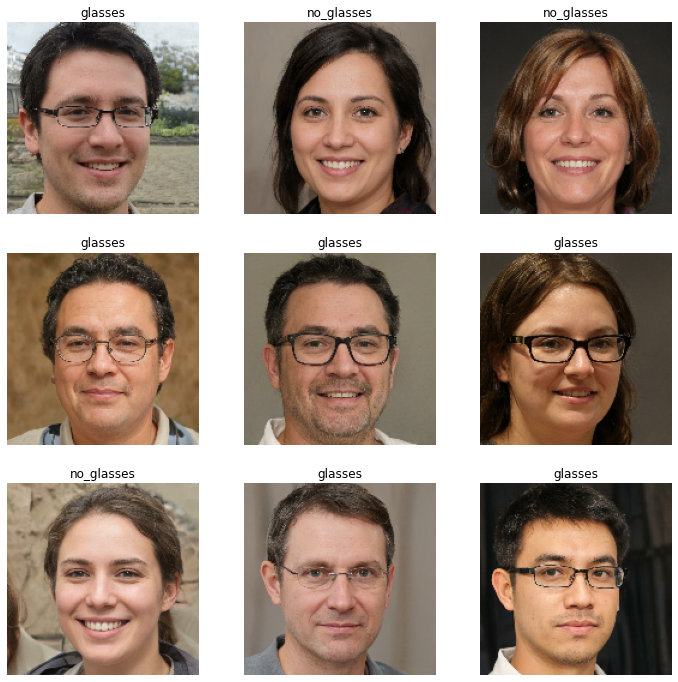

In [37]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Currently we have the `train_dataset` and `validation_dataset` created, however it is important to have also a `small split to test the model`, test_dataset. This will be `20% of the validation_dataset`, this means, more or less `6%`

In [38]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [39]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 108
Number of validation batches: 38
Number of test batches: 9


## This configuration allows the model to speed up the training process¶

## The Dataset.prefetch() function used in the three splits, overlaps data preprocessing and model execution during the training process

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# 3) Preparing base model:

## 3.1) Data augmentation¶

### Data augmentation is an optional step which introduces several artificial observations to the training sample.
### In this model we are going to introduce two data augmentations:¶

In [41]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Below we can find the results of the data augmentation:

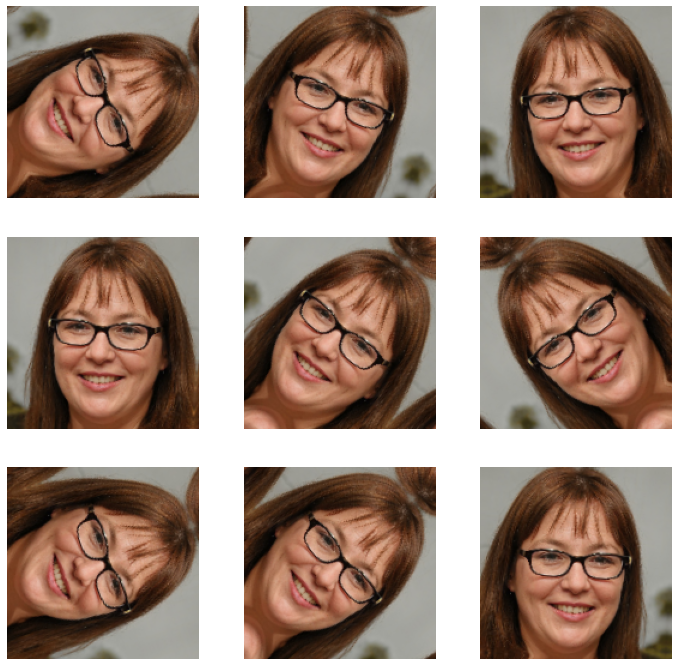

In [42]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 3.2) Rescale pixel values:¶

### Firstly, the application `MobileNetV2` will be downloaded, which is going to be used as a base for the model. This is a way of performing transfer learning, which consists in using a training learning from a pre-trained network

In [45]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### This model expects `pixel values between -1 and 1`, hence the images should be `preprocessed`

In [46]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## 3.3) Creating base model from MobileNet V2

### The base model `MobileNet V2` was developed by Google
### It contains a large dataset with `1.4 million of images` and `1000 classes`
### It is important to include `include_top=False` because the classification layers previously created should be included

In [47]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


### This feature extractor converts the images from `160x160x3` to `5x5x1280`

In [48]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 3.4) Feature extraction

### First of all, we should `freeze the convolutional base` created from the previous step, because it is going to be used as a `feature extractor`

In [49]:
base_model.trainable = False

## 3.5) Adding classification head

### The layer `tf.keras.layers.GlobalAveragePooling2D` is going to be used, in order to convert the features in a `1280-element vector`, per each image

In [50]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


### `tf.keras.layers.Dense` is a layer that converts the features into a `single prediction`

In [51]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### It is time to apply the previous process to the model:
- `Data augmentation`
- `Rescaling`
- `Basel model`
- `Feature extractor`

In [52]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## 3.6) Compilation of the model:

In [53]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [54]:
%%time
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Wall time: 8 ms


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### There are `two variable objects`. Divided between around `2.5 million of MobilNet` parameters which are `frozen`, and `1.2 thousend` of trainable parameter in the `Dense layer`

In [55]:
len(model.trainable_variables)

2

## 3.7) Training the model

In [56]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

38/38 [==============================] - 8s 177ms/step - loss: 0.7147 - accuracy: 0.5909


In [57]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.59


In [58]:
model_fit = model.fit(train_dataset,
                    epochs= initial_epochs,
                    validation_data= validation_dataset)

Epoch 1/10
108/108 [==============================] - 29s 260ms/step - loss: 0.7041 - accuracy: 0.5964 - val_loss: 0.6096 - val_accuracy: 0.6591
Epoch 2/10
108/108 [==============================] - 28s 259ms/step - loss: 0.5551 - accuracy: 0.7091 - val_loss: 0.5397 - val_accuracy: 0.7247
Epoch 3/10
108/108 [==============================] - 28s 259ms/step - loss: 0.4596 - accuracy: 0.7692 - val_loss: 0.4803 - val_accuracy: 0.7626
Epoch 4/10
108/108 [==============================] - 28s 262ms/step - loss: 0.3996 - accuracy: 0.8139 - val_loss: 0.4381 - val_accuracy: 0.8114
Epoch 5/10
108/108 [==============================] - 29s 268ms/step - loss: 0.3543 - accuracy: 0.8464 - val_loss: 0.4005 - val_accuracy: 0.8274
Epoch 6/10
108/108 [==============================] - 29s 270ms/step - loss: 0.3177 - accuracy: 0.8673 - val_loss: 0.3667 - val_accuracy: 0.8569
Epoch 7/10
108/108 [==============================] - 29s 269ms/step - loss: 0.2964 - accuracy: 0.8812 - val_loss: 0.3410 - val_ac

In [59]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

In [60]:
## 3.8) Results

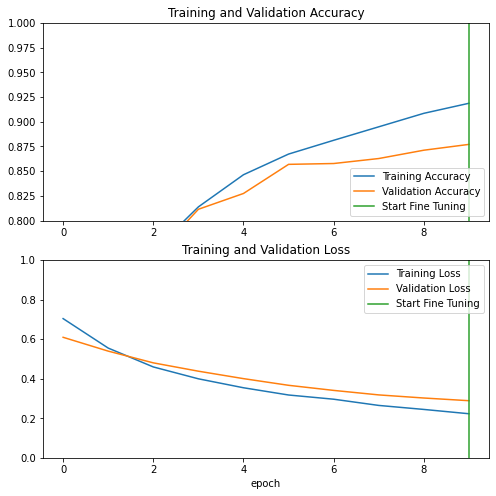

In [61]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### As it can be seen in the graphs the `accuracy` along the `10 epochs` was `really similar` for the `validation` and `training` samples
### However, it seems that for some epochs the model works slighty better in the `validation sample` than in the `training sample`. This probably happened due to the application of some layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout`, which are applied during the `training process`

In [62]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

108/108 [==============================] - 21s 189ms/step - loss: 0.2709 - accuracy: 0.8897
Test accuracy : 0.90625
Train accuracy : 0.8896631598472595


# 4) Model with fine tunning

### This model is a continuation of the `Model 1`, however, a `fine tunning`process will be applied in order to `increase the performance`
### During the previos process the `weights of the pre-trained network` were `not updated` during the training.
### However, it is possible to increase the performance applying these `weights`

## 4.1) Unfreeze the top layers of the model

In [63]:
base_model.trainable = True

In [64]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


## 4.2) Compile the model

In [65]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [66]:
len(model.trainable_variables)

56

## 4.3) Training the model

In [67]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= validation_dataset)

Epoch 10/15
108/108 [==============================] - 41s 360ms/step - loss: 0.0699 - accuracy: 0.9750 - val_loss: 0.0474 - val_accuracy: 0.9865
Epoch 11/15
108/108 [==============================] - 38s 355ms/step - loss: 0.0277 - accuracy: 0.9922 - val_loss: 0.0305 - val_accuracy: 0.9933
Epoch 12/15
108/108 [==============================] - 39s 357ms/step - loss: 0.0186 - accuracy: 0.9930 - val_loss: 0.0153 - val_accuracy: 0.9949
Epoch 13/15
108/108 [==============================] - 43s 400ms/step - loss: 0.0169 - accuracy: 0.9936 - val_loss: 0.0144 - val_accuracy: 0.9958
Epoch 14/15
108/108 [==============================] - 40s 365ms/step - loss: 0.0111 - accuracy: 0.9968 - val_loss: 0.0221 - val_accuracy: 0.9966
Epoch 15/15
108/108 [==============================] - 39s 362ms/step - loss: 0.0116 - accuracy: 0.9959 - val_loss: 0.0218 - val_accuracy: 0.9949


In [68]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']

## 4.4) Results

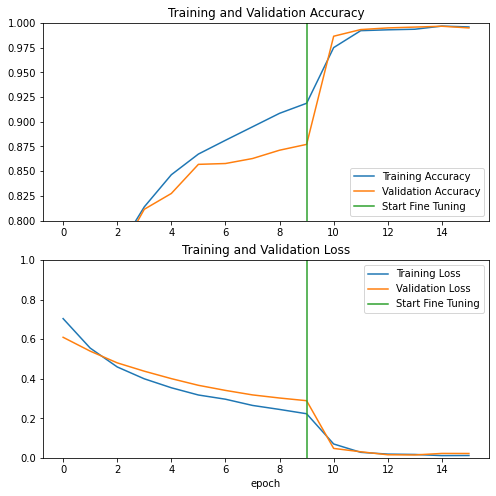

In [69]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [70]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
loss, accuracy2 = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)
print('Validation accuracy :', accuracy2)

38/38 [==============================] - 8s 208ms/step - loss: 0.0291 - accuracy: 0.9933
Test accuracy : 0.9930555820465088
Train accuracy : 0.9970964193344116
Validation accuracy : 0.9932659864425659


### As it can be seen in the `training` and `test`samples the accuracy is really high, greater than 0.99, hence this `model is robust` and `works really well`

# 5) Prediction

### In this case the `Model 2 with fine tuning` will be applied, as the performance of the same was better. The prediction is going to be done in the `test sample`

Predictions:
 [0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1]
Labels:
 [0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1]


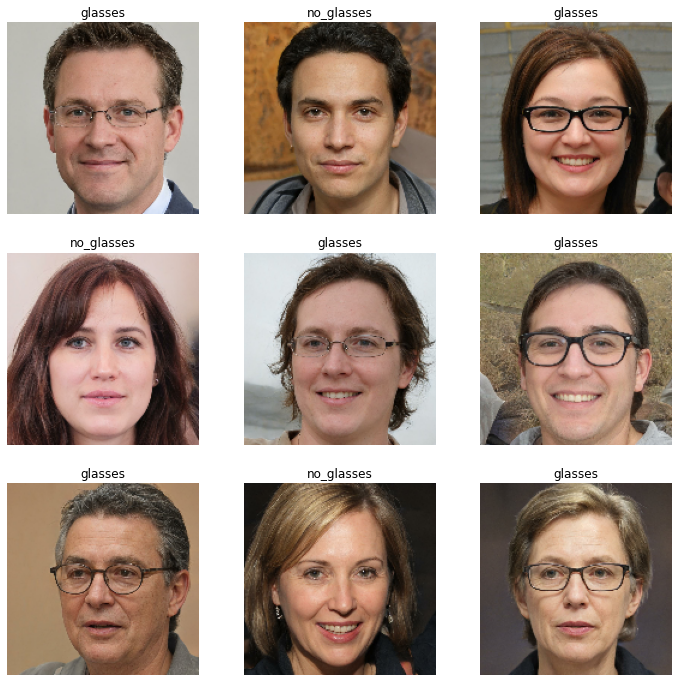

In [71]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

### As per the results, it looks like that the `model classified perfectly the images`, it can be seen that the array of `Predictions` is the same as `Labels`

In [72]:
model.save("best_model")

C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: best_model\assets
